# The Goal of this Project

*In this project, your goal is to write a software pipeline to identify cars in a video from a front-facing camera on a car.* 

## Project Steps
1. Gather training examples
2. Perform Feature Engineering
3. Train and evaluate different classifiers
4. Perspective Spatial Transform (window search)
5. Classify
6. Filter false-positives
7. Show live detection on video

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# Divide up into cars and notcars
cars = glob.glob('./training/vehicles/GTI_*/*.png')
# cars.extend(glob.glob('./training/vehicles/GTI_*/*.jpg'))
# cars.extend(glob.glob('./training/vehicles/KIT*/*.png'))
notcars = glob.glob('./training/non-vehicles/GTI/*.png')
# notcars.extend(glob.glob('./training/non-vehicles/Ex*/*.png'))


In [2]:
# fnames = glob.glob('./training/vehicles/GTI_*/*.jpg')
# for fname in fnames:
#     ima = cv2.imread(fname)
#     ima = cv2.resize(ima, (64,64))
#     cv2.imwrite(fname, ima)
# glob.glob('./training/vehicles/GTI_*/*.jpg')

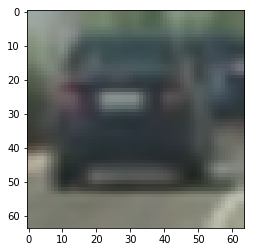

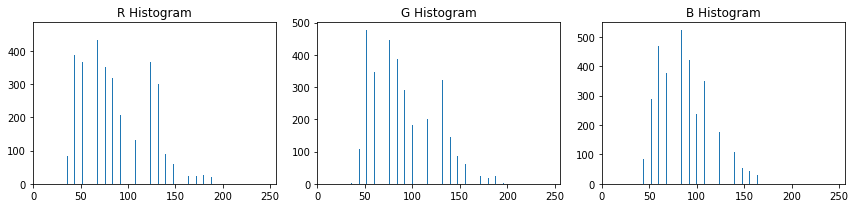

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
img = cv2.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
rh, gh, bh, bincen, feature_vec = color_hist(img, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

Text(0.5,1,'Spatially Binned Features')

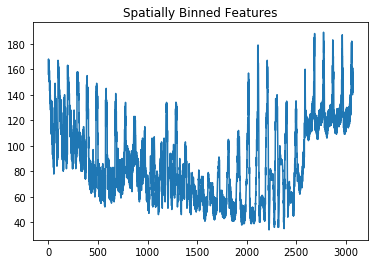

In [4]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, size=(32, 32)):
             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(img, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [5]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Text(0.5,1,'HOG Visualization')

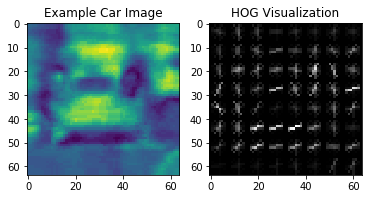

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray[:,:,2])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='NON', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    file_features = []
    # Read in each one by one
#     image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    # Convert image to new color space (if specified)
    if color_space != 'NON':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        # KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
        # IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
        # cv2.imread() INSTEAD YOU START WITH BGR COLOR!
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else: feature_image = np.copy(image)    

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
#         print(file_features)
    return np.concatenate(file_features)

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='NON', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        image = mpimg.imread(file)
        
        feature = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features.append(feature)
        
    # Return list of feature vectors
    return features

In [9]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars[:len(cars)], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
print(len(notcar_features))

2826
2826


In [10]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import time
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

if X.shape[0] != y.shape[0]:
    assert("feature and labels don't match")

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
clf_svm = LinearSVC()
clf_gnb = GaussianNB()
# Check the training time for the SVC
t=time.time()
clf_svm.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(clf_svm.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(clf_svm.score(X_test, y_test), 4))
t=time.time()
clf_gnb.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train GNB...')
# Check the score of the naieve bayes
print('Train Accuracy of GNB = ', round(clf_gnb.score(X_train, y_train), 4))
print('Test Accuracy of GNB = ', round(clf_gnb.score(X_test, y_test), 4))

C:\Users\hayesmat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
2.21 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9876
0.87 Seconds to train GNB...
Train Accuracy of GNB =  0.9199
Test Accuracy of GNB =  0.9195


In [11]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [45]:
# image = mpimg.imread('./test_images/test3.jpg')
image = mpimg.imread('../CarND-Advanced-Lane-Lines-master/output_images/input_frame0555.jpg')
# search_dict[0] = [x_start_stop=[440, 840], y_start_stop=[400, (720//4)*3], xy_window=(64, 64), xy_overlap=(0.5, 0.5)] 
# x_start_stop=[None, None], y_start_stop=[400, 600], xy_window=(128, 128), xy_overlap=(0.5, 0.5)
# x_start_stop=[None, None], y_start_stop=[300, None], xy_window=(256, 256), xy_overlap=(0.5, 0.5)


In [46]:
windows_med = slide_window(image, x_start_stop=[480, 1280], y_start_stop=[400, 720], xy_window=(200, 200), xy_overlap=(0.8, 0.8))
windows_far = slide_window(image, x_start_stop=[650, 1150], y_start_stop=[410, 630], xy_window=(100, 100), xy_overlap=(0.8, 0.8))
windows_nar = slide_window(image, x_start_stop=[600, 1100], y_start_stop=[370, 550], xy_window=(70, 70), xy_overlap=(0.8, 0.8))

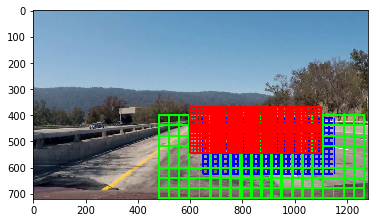

In [47]:
window_img = image
window_img = draw_boxes(window_img, windows_far, color=(0, 0, 255), thick=6)
window_img = draw_boxes(window_img, windows_med, color=(0, 255, 0), thick=6)
window_img = draw_boxes(window_img, windows_nar, color=(255, 0, 0), thick=6)
plt.imshow(window_img)

524


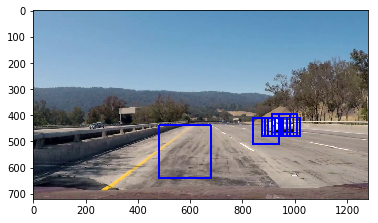

In [48]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, bboxes):#, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    box_fm1 = []
    box_fm2 = []
    # Iterate through the bounding boxes
    for bbox in bboxes:
        
#         print(bbox)
#         print('ytop: '+ str(bbox[0][1]) +' ytop+window: ' + str(bbox[1][1]) + ' xleft: '+ str(bbox[0][0]) +' xleft+window: ' + str(bbox[1][0]))
        
        # Extract the image patch
        subimg = cv2.resize(img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]], (64,64))
        
        #extract features
        features = single_img_features(subimg, color_space='HLS', spatial_size=(32, 32), hist_bins=32, 
                                       hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
        
        # Apply the scaler to the features
        norm_features = X_scaler.transform([features,])
        
        #classify if car present
        if clf_svm.predict(norm_features):# and clf_gnb.predict(norm_features):
            box_fm1.append(bbox)
            box_fm2.extend(bbox)
            
    return box_fm1, box_fm2
            
        
windows = []
windows.extend(windows_far)
windows.extend(windows_med)
windows.extend(windows_nar)
print(len(windows) )       
box_fm1, box_fm2 = find_cars(image, windows)   
window_img = draw_boxes(image, box_fm1, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

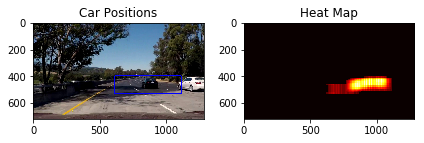

In [57]:
import itertools
from scipy.ndimage.measurements import label
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
#         for box in item:
#         print(box)
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        x_range = np.max(nonzerox)-np.min(nonzerox)
        y_range = np.max(nonzeroy)-np.min(nonzeroy)
        try:
            ratio = float(x_range)/float(y_range)
        except:
            ratio = 4.0
        if ratio < 4.0 and ratio > 1/4.0 and np.min((x_range, y_range)) > 30:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_fm1)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# print(labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0000.jpg


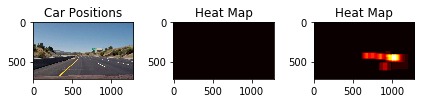

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0001.jpg


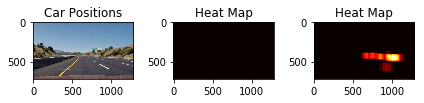

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0002.jpg


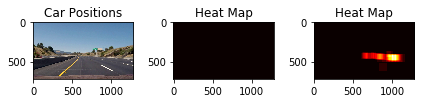

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0003.jpg


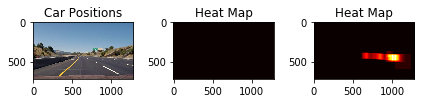

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0004.jpg


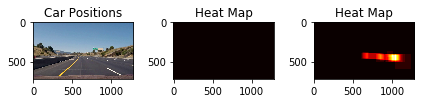

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0005.jpg


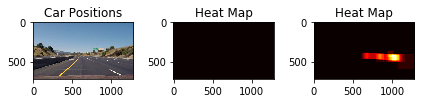

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0006.jpg


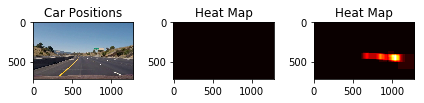

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0007.jpg


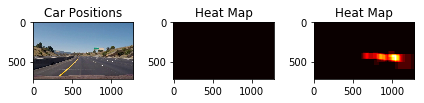

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0008.jpg


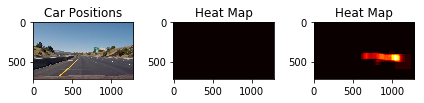

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0009.jpg


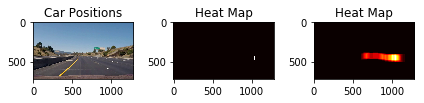

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0010.jpg


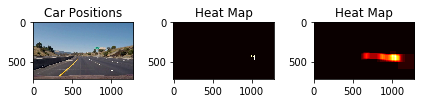

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0011.jpg


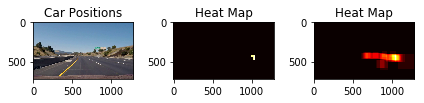

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0012.jpg


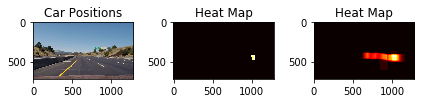

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0013.jpg


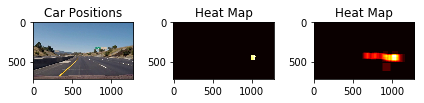

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0014.jpg


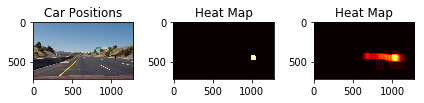

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0015.jpg


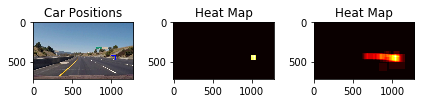

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0016.jpg


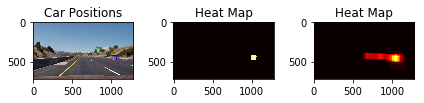

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0017.jpg


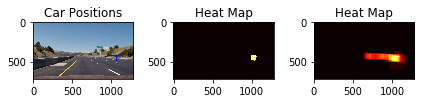

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0018.jpg


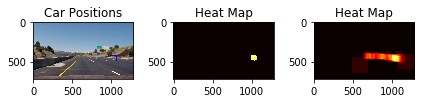

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0019.jpg


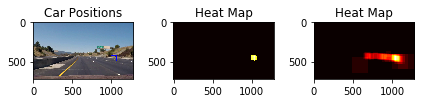

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0020.jpg


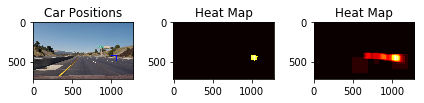

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0021.jpg


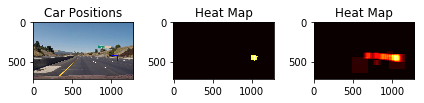

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0022.jpg


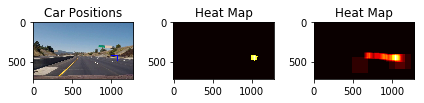

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0023.jpg


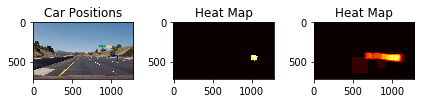

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0024.jpg


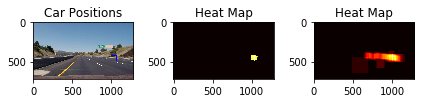

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0025.jpg


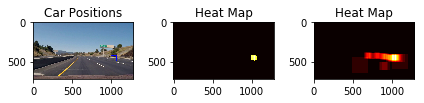

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0026.jpg


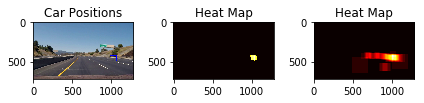

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0027.jpg


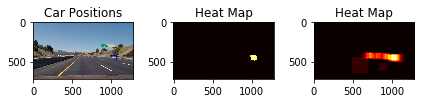

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0028.jpg


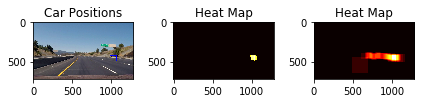

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0029.jpg


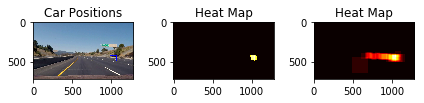

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0030.jpg


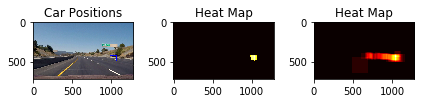

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0031.jpg


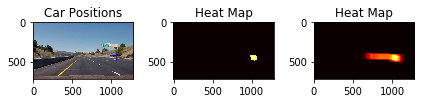

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0032.jpg


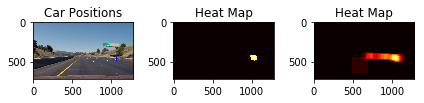

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0033.jpg


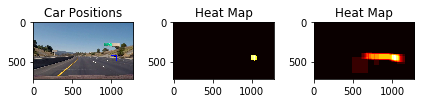

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0034.jpg


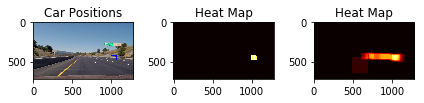

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0035.jpg


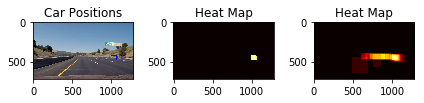

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0036.jpg


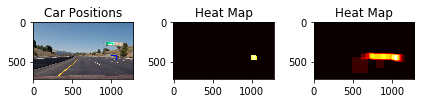

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0037.jpg


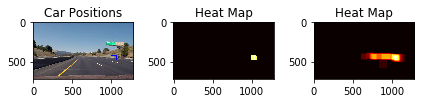

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0038.jpg


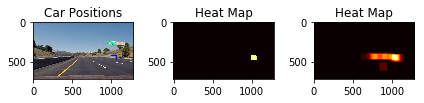

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0039.jpg


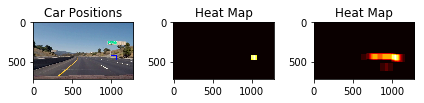

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0040.jpg


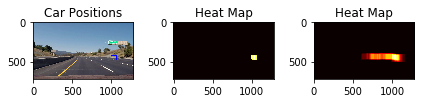

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0041.jpg


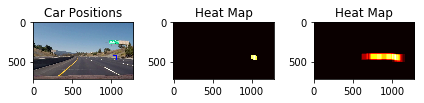

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0042.jpg


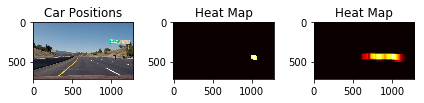

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0043.jpg


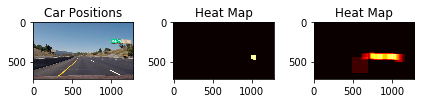

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0044.jpg


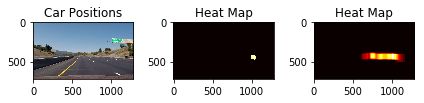

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0045.jpg


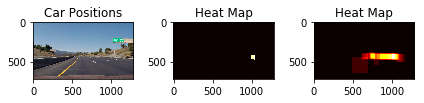

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0046.jpg


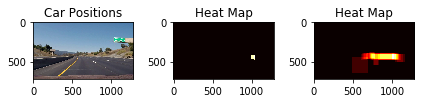

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0047.jpg


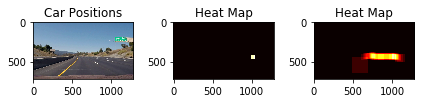

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0048.jpg


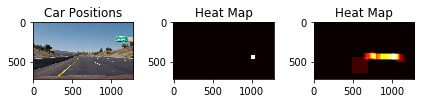

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0049.jpg


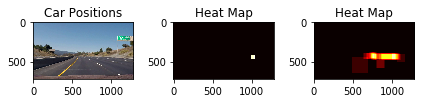

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0050.jpg


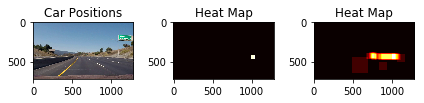

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0051.jpg


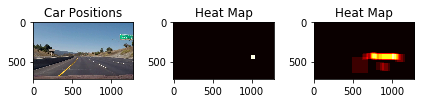

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0052.jpg


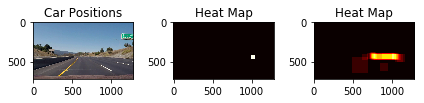

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0053.jpg


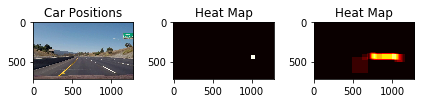

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0054.jpg


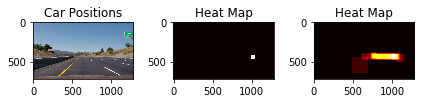

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0055.jpg


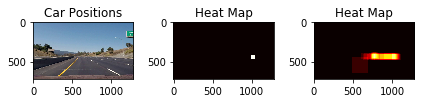

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0056.jpg


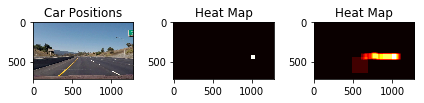

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0057.jpg


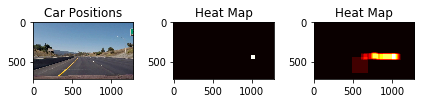

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0058.jpg


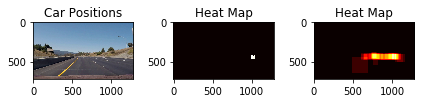

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0059.jpg


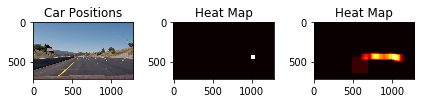

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0060.jpg


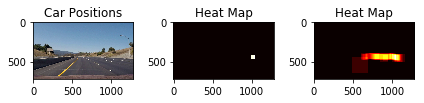

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0061.jpg


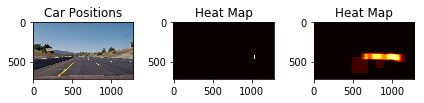

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0062.jpg


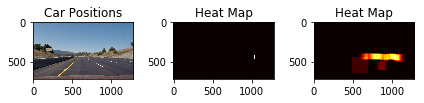

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0063.jpg


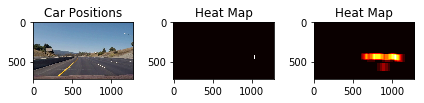

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0064.jpg


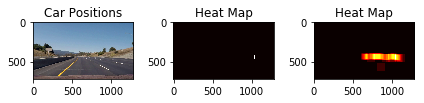

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0065.jpg


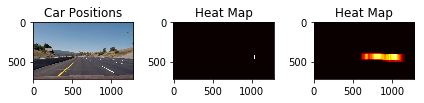

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0066.jpg


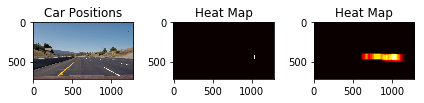

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0067.jpg


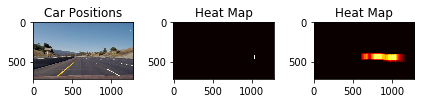

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0068.jpg


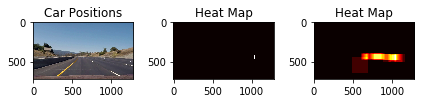

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0069.jpg


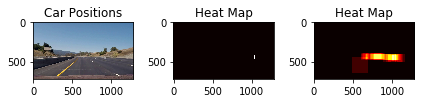

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0070.jpg


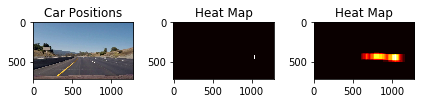

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0071.jpg


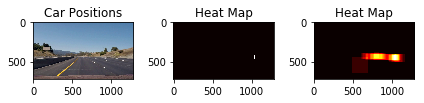

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0072.jpg


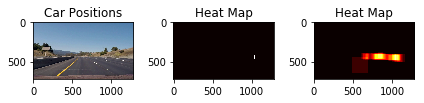

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0073.jpg


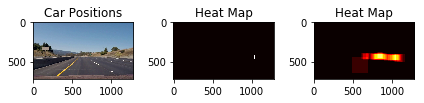

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0074.jpg


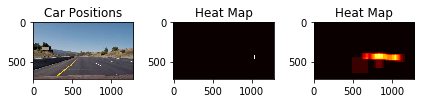

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0075.jpg


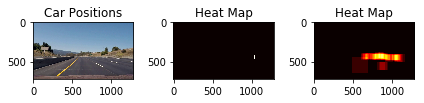

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0076.jpg


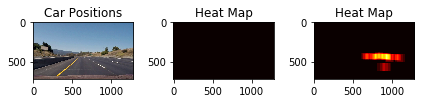

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0077.jpg


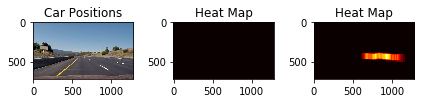

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0078.jpg


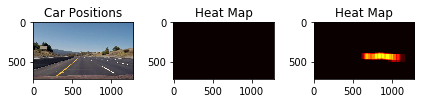

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0079.jpg


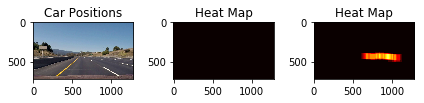

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0080.jpg


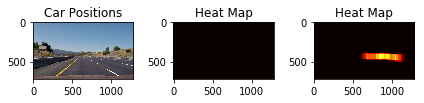

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0081.jpg


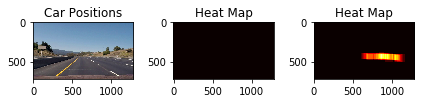

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0082.jpg


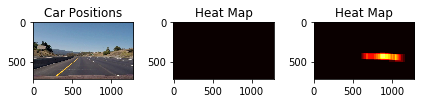

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0083.jpg


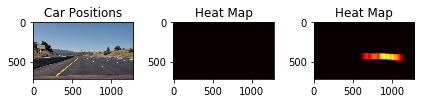

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0084.jpg


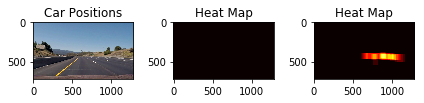

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0085.jpg


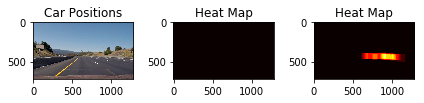

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0086.jpg


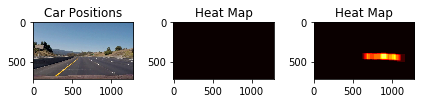

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0087.jpg


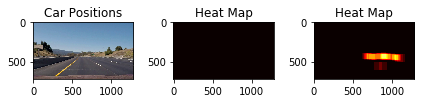

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0088.jpg


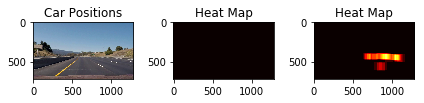

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0089.jpg


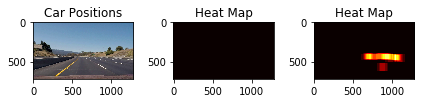

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0090.jpg


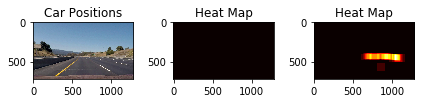

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0091.jpg


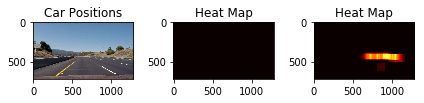

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0092.jpg


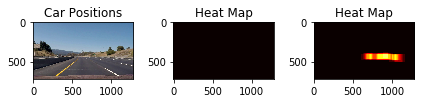

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0093.jpg


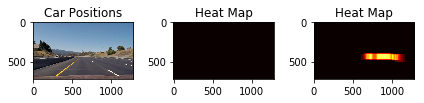

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0094.jpg


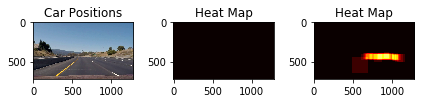

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0095.jpg


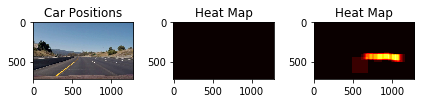

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0096.jpg


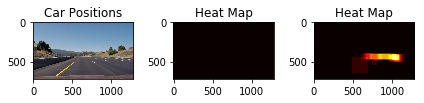

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0097.jpg


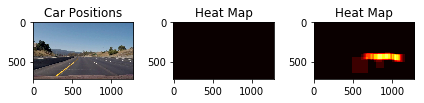

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0098.jpg


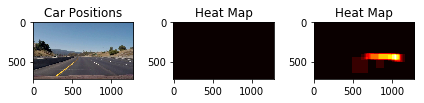

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0099.jpg


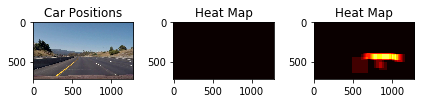

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0100.jpg


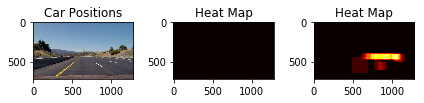

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0101.jpg


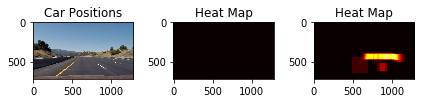

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0102.jpg


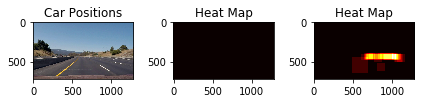

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0103.jpg


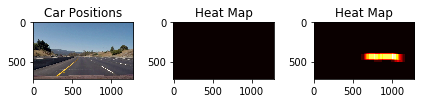

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0104.jpg


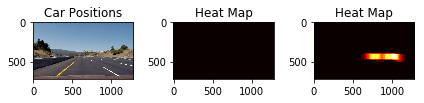

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0105.jpg


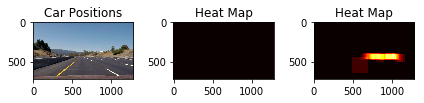

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0106.jpg


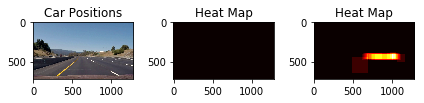

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0107.jpg


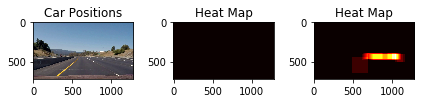

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0108.jpg


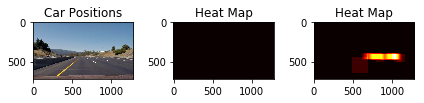

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0109.jpg


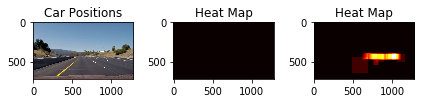

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0110.jpg


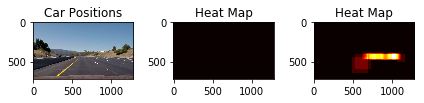

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0111.jpg


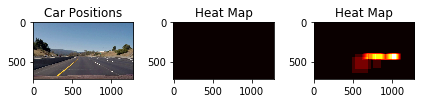

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0112.jpg


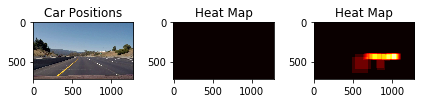

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0113.jpg


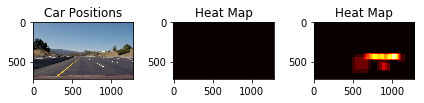

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0114.jpg


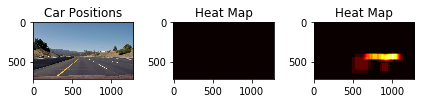

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0115.jpg


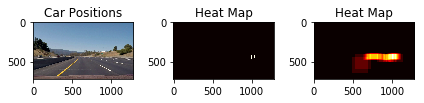

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0116.jpg


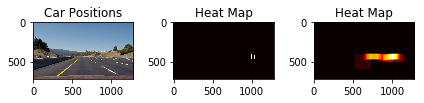

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0117.jpg


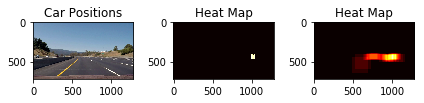

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0118.jpg


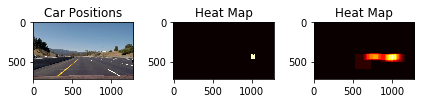

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0119.jpg


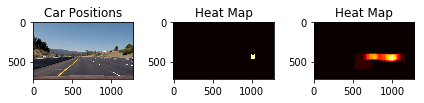

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0120.jpg


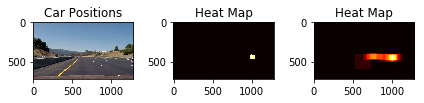

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0121.jpg


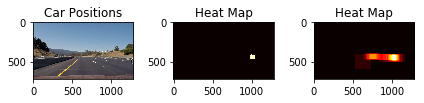

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0122.jpg


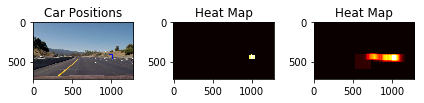

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0123.jpg


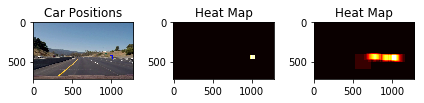

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0124.jpg


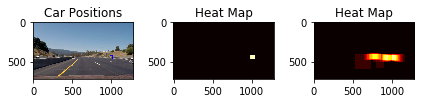

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0125.jpg


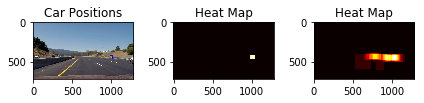

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0126.jpg


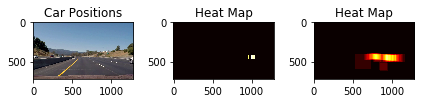

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0127.jpg


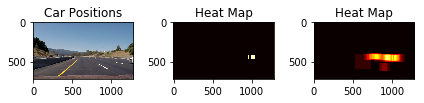

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0128.jpg


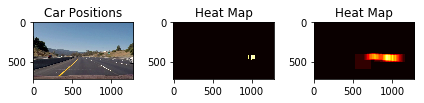

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0129.jpg


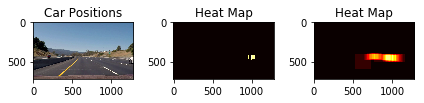

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0130.jpg


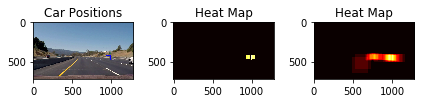

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0131.jpg


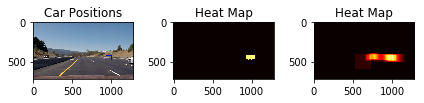

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0132.jpg


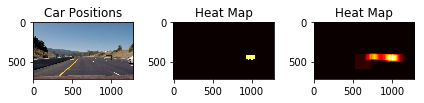

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0133.jpg


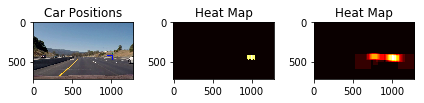

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0134.jpg


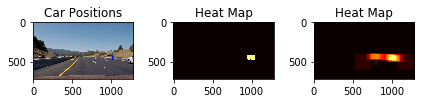

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0135.jpg


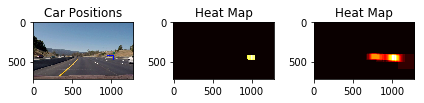

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0136.jpg


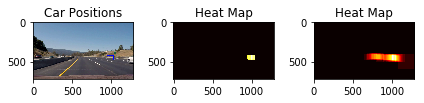

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0137.jpg


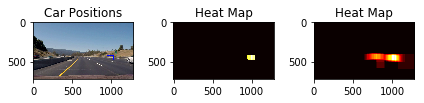

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0138.jpg


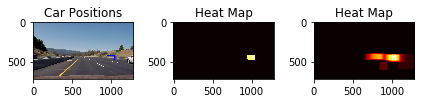

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0139.jpg


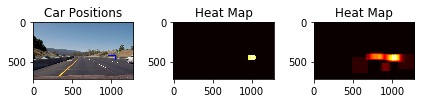

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0140.jpg


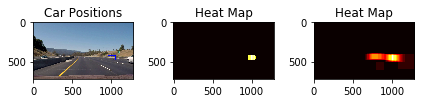

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0141.jpg


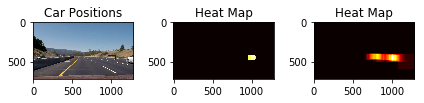

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0142.jpg


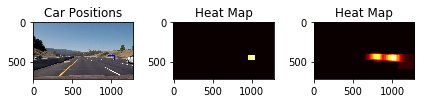

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0143.jpg


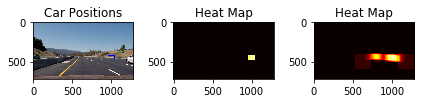

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0144.jpg


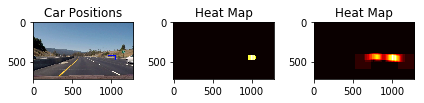

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0145.jpg


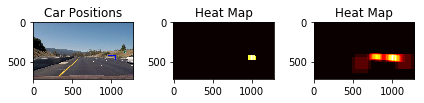

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0146.jpg


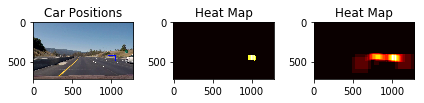

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0147.jpg


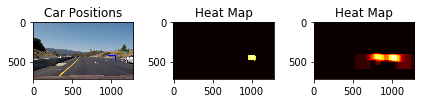

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0148.jpg


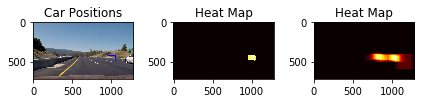

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0149.jpg


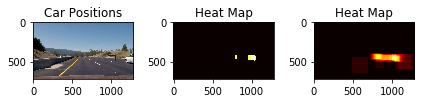

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0150.jpg


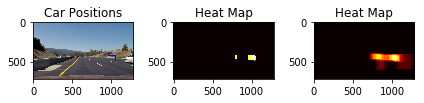

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0151.jpg


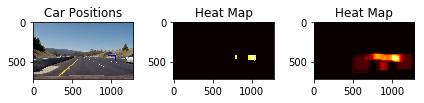

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0152.jpg


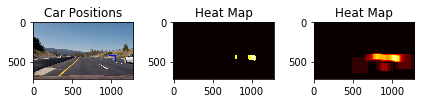

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0153.jpg


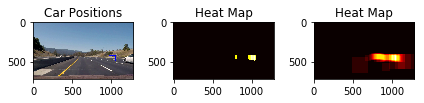

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0154.jpg


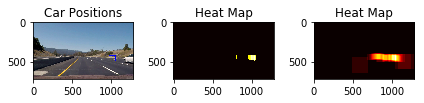

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0155.jpg


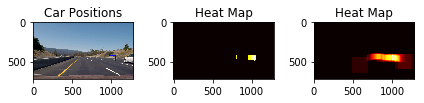

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0156.jpg


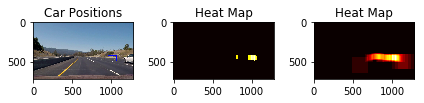

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0157.jpg


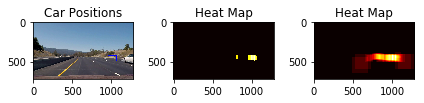

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0158.jpg


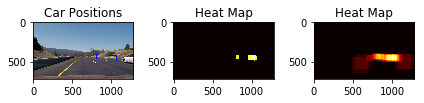

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0159.jpg


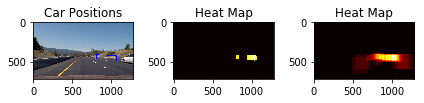

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0160.jpg


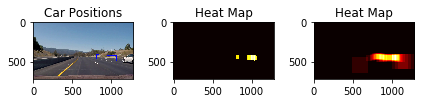

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0161.jpg


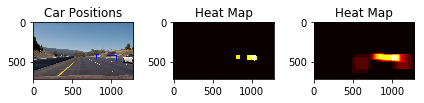

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0162.jpg


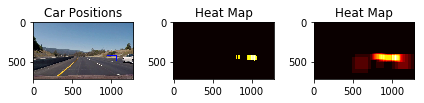

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0163.jpg


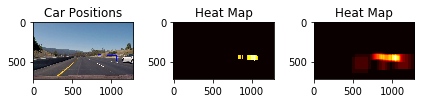

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0164.jpg


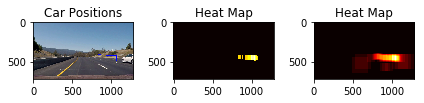

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0165.jpg


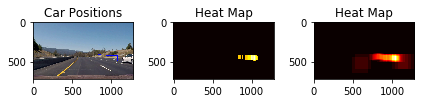

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0166.jpg


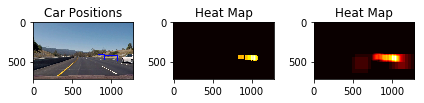

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0167.jpg


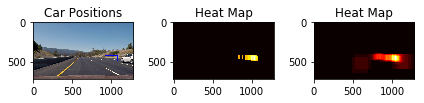

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0168.jpg


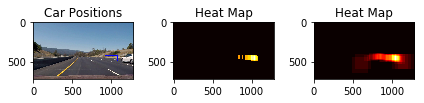

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0169.jpg


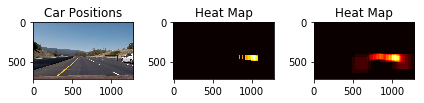

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0170.jpg


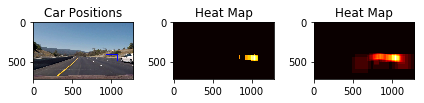

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0171.jpg


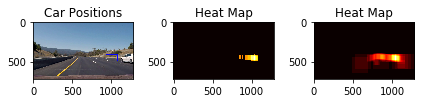

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0172.jpg


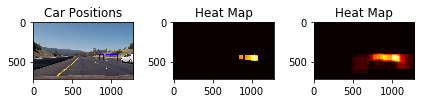

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0173.jpg


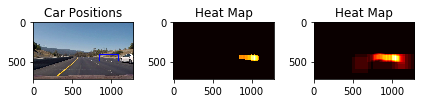

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0174.jpg


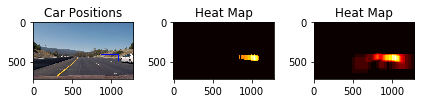

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0175.jpg


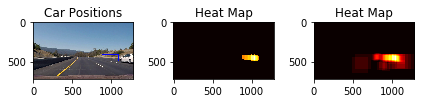

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0176.jpg


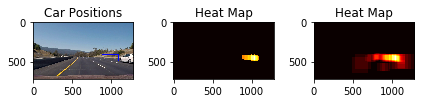

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0177.jpg


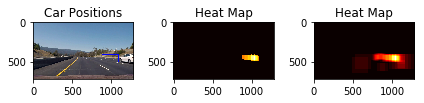

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0178.jpg


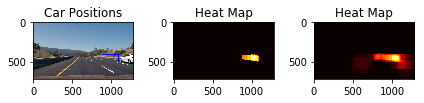

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0179.jpg


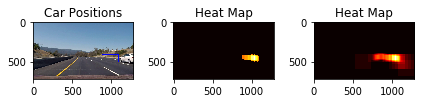

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0180.jpg


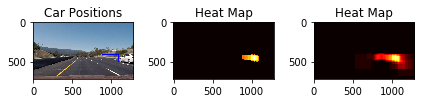

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0181.jpg


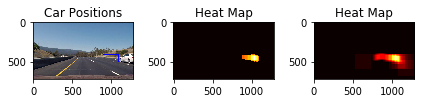

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0182.jpg


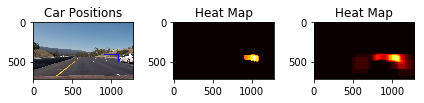

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0183.jpg


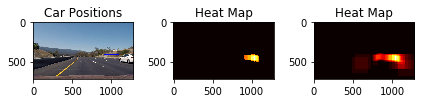

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0184.jpg


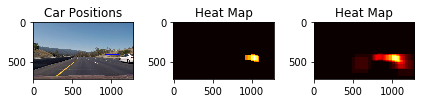

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0185.jpg


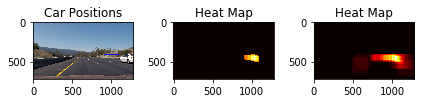

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0186.jpg


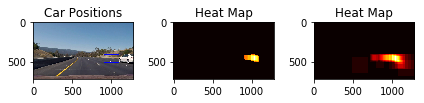

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0187.jpg


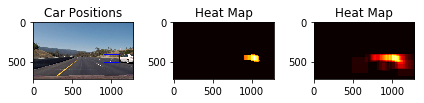

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0188.jpg


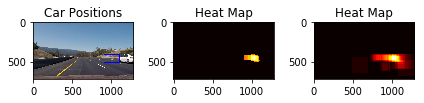

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0189.jpg


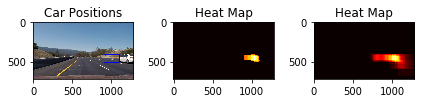

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0190.jpg


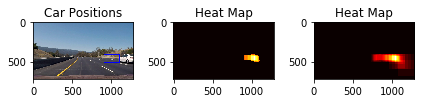

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0191.jpg


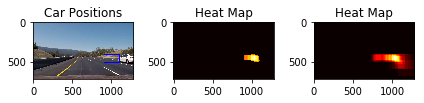

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0192.jpg


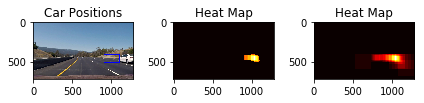

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0193.jpg


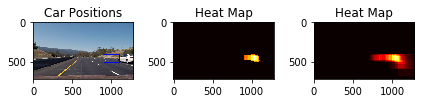

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0194.jpg


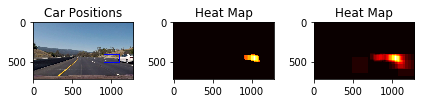

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0195.jpg


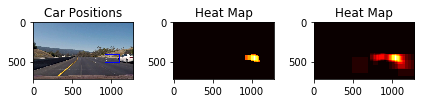

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0196.jpg


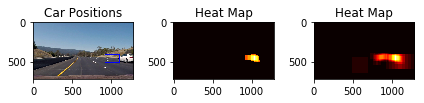

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0197.jpg


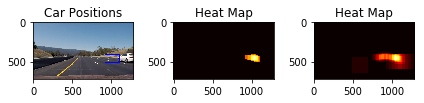

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0198.jpg


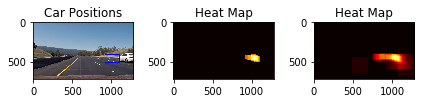

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0199.jpg


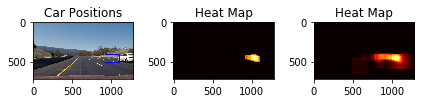

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0200.jpg


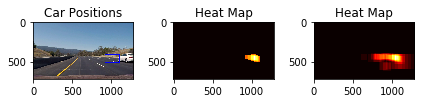

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0201.jpg


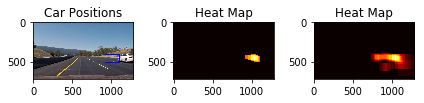

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0202.jpg


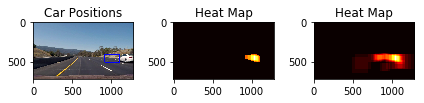

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0203.jpg


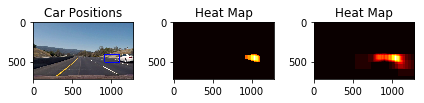

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0204.jpg


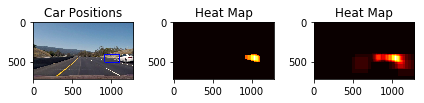

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0205.jpg


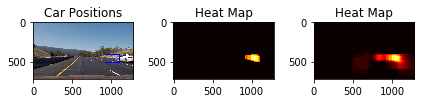

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0206.jpg


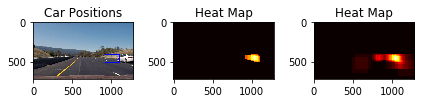

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0207.jpg


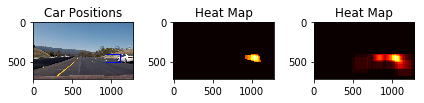

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0208.jpg


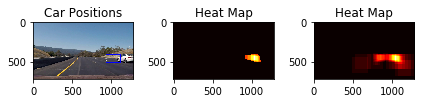

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0209.jpg


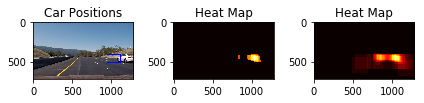

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0210.jpg


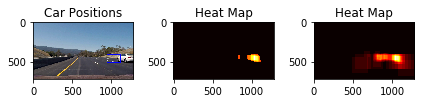

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0211.jpg


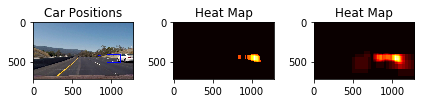

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0212.jpg


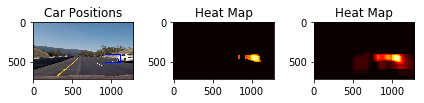

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0213.jpg


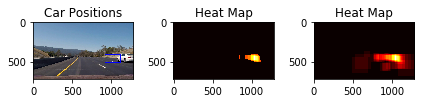

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0214.jpg


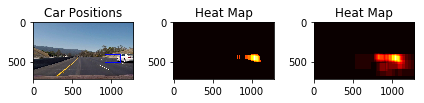

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0215.jpg


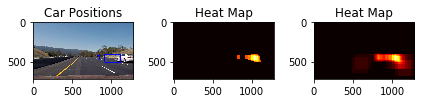

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0216.jpg


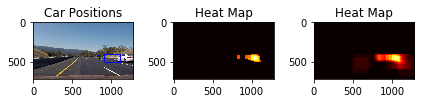

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0217.jpg


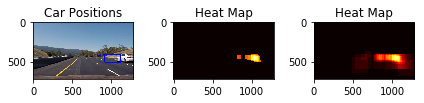

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0218.jpg


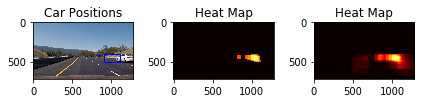

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0219.jpg


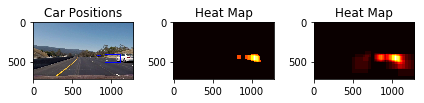

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0220.jpg


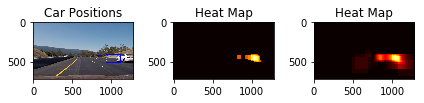

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0221.jpg


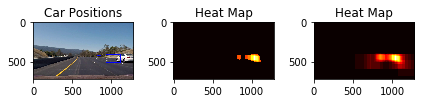

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0222.jpg


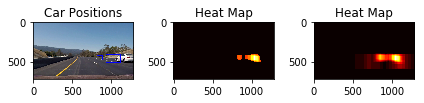

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0223.jpg


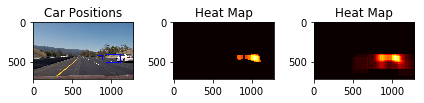

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0224.jpg


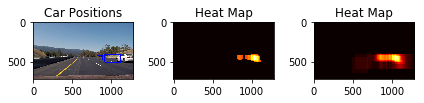

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0225.jpg


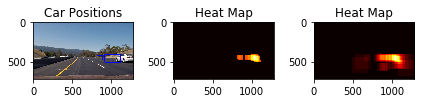

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0226.jpg


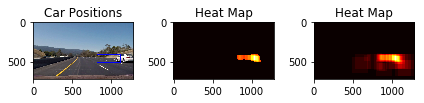

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0227.jpg


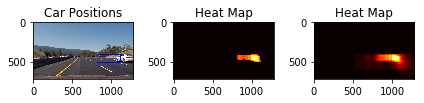

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0228.jpg


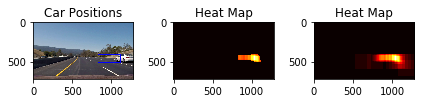

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0229.jpg


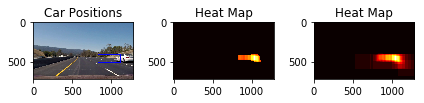

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0230.jpg


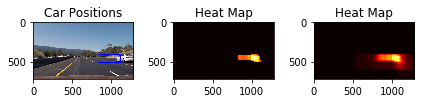

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0231.jpg


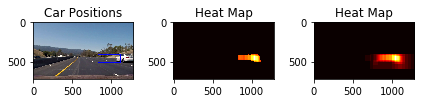

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0232.jpg


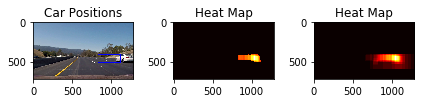

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0233.jpg


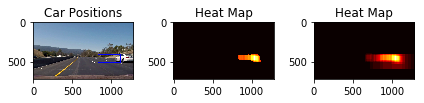

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0234.jpg


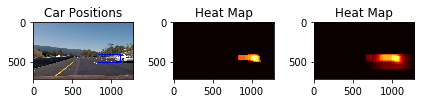

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0235.jpg


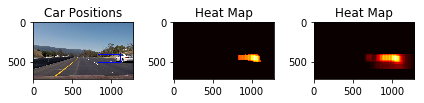

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0236.jpg


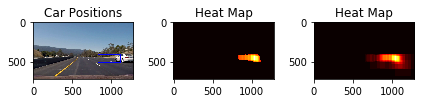

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0237.jpg


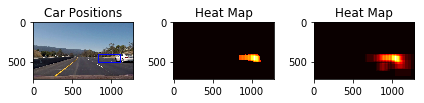

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0238.jpg


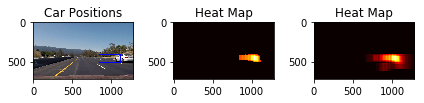

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0239.jpg


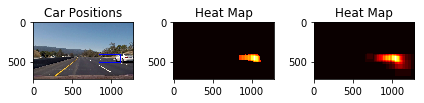

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0240.jpg


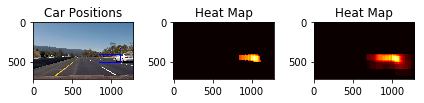

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0241.jpg


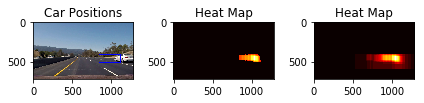

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0242.jpg


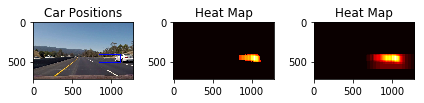

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0243.jpg


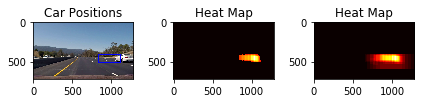

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0244.jpg


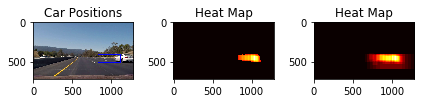

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0245.jpg


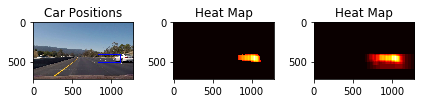

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0246.jpg


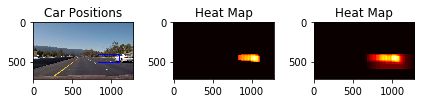

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0247.jpg


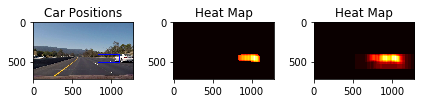

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0248.jpg


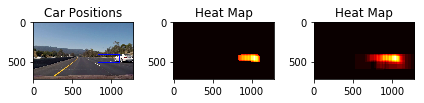

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0249.jpg


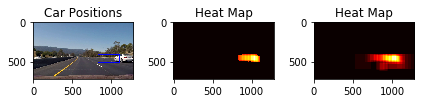

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0250.jpg


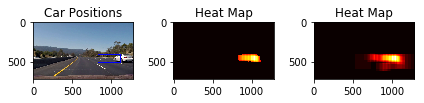

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0251.jpg


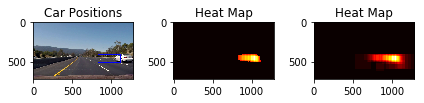

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0252.jpg


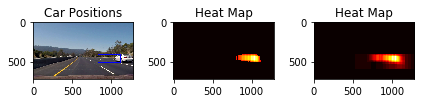

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0253.jpg


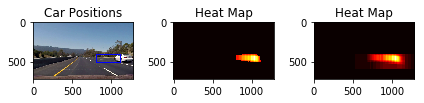

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0254.jpg


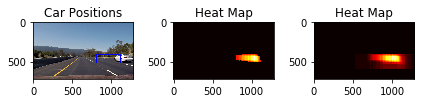

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0255.jpg


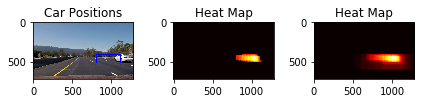

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0256.jpg


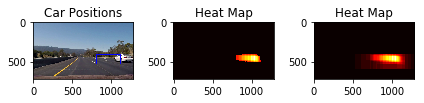

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0257.jpg


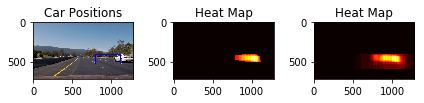

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0258.jpg


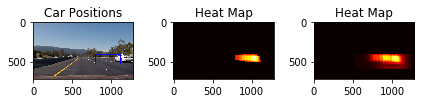

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0259.jpg


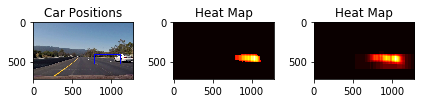

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0260.jpg


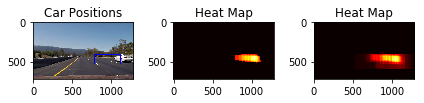

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0261.jpg


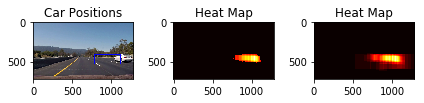

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0262.jpg


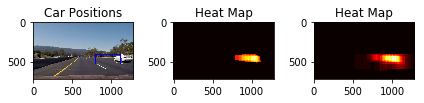

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0263.jpg


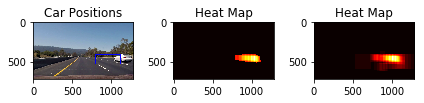

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0264.jpg


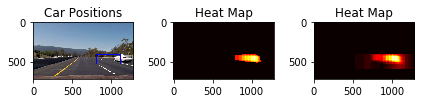

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0265.jpg


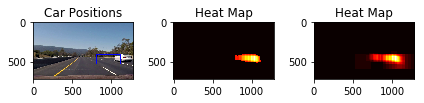

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0266.jpg


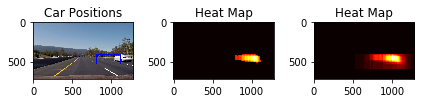

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0267.jpg


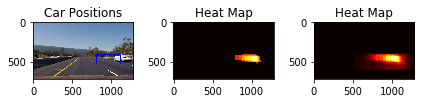

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0268.jpg


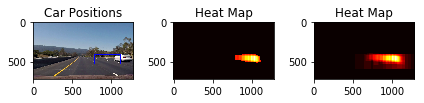

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0269.jpg


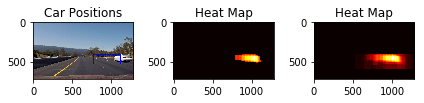

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0270.jpg


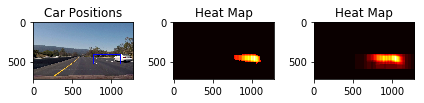

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0271.jpg


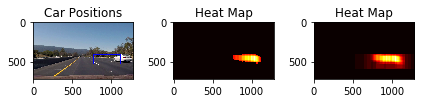

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0272.jpg


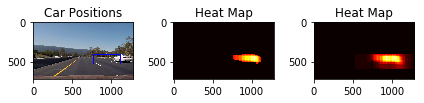

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0273.jpg


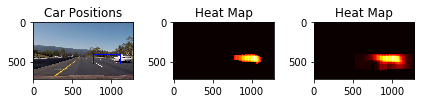

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0274.jpg


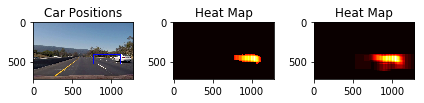

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0275.jpg


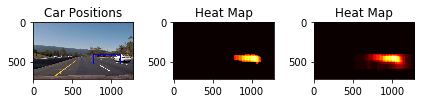

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0276.jpg


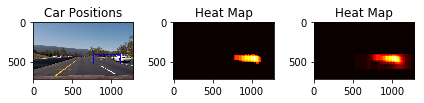

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0277.jpg


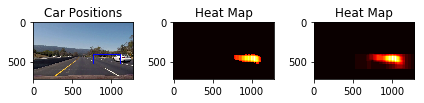

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0278.jpg


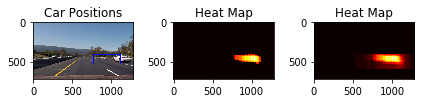

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0279.jpg


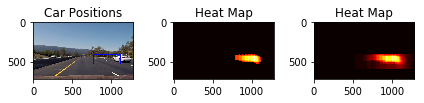

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0280.jpg


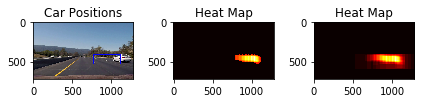

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0281.jpg


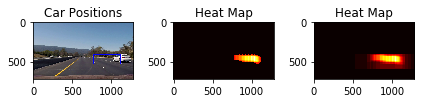

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0282.jpg


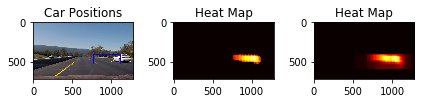

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0283.jpg


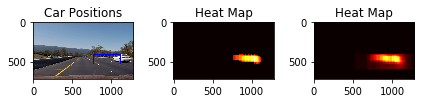

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0284.jpg


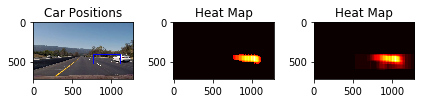

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0285.jpg


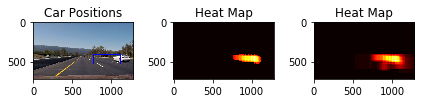

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0286.jpg


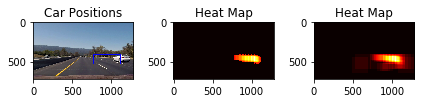

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0287.jpg


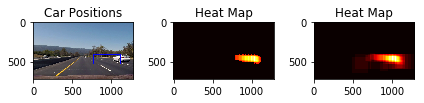

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0288.jpg


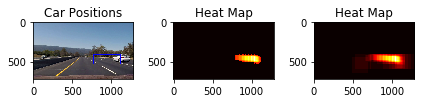

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0289.jpg


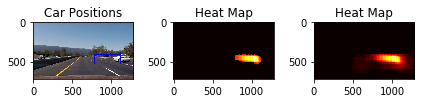

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0290.jpg


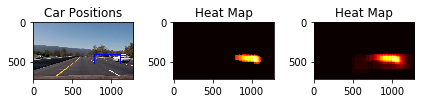

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0291.jpg


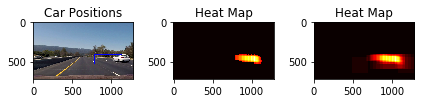

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0292.jpg


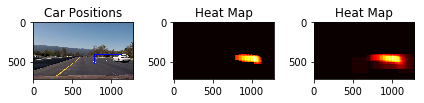

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0293.jpg


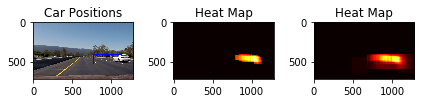

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0294.jpg


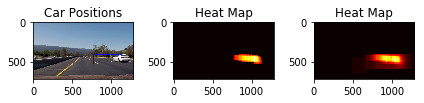

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0295.jpg


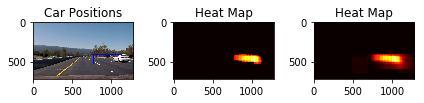

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0296.jpg


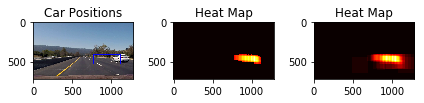

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0297.jpg


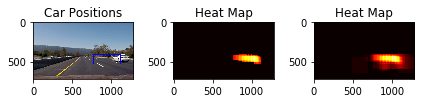

../CarND-Advanced-Lane-Lines-master/output_images\input_frame0298.jpg


In [ ]:
%matplotlib inline
fnames = glob.glob('../CarND-Advanced-Lane-Lines-master/output_images/input_frame****.jpg')

heat_z = np.zeros_like(image[:,:,0]).astype(np.float)
alpha = 0.1

for i, fname in enumerate(fnames):
    print(fname)

    if i > -1: 
        image = mpimg.imread(fname)

        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        box_fm1, box_fm2 = find_cars(image, windows)   

        # Add heat to each box in box list
        heat = add_heat(heat,box_fm1)

        # Apply threshold to help remove false positives
    #     heat = apply_threshold(heat,6)

        heat_z = alpha*heat + (1-alpha)*heat_z

        heat_cp = np.copy(heat_z)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_cp, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(apply_threshold(heatmap,12))
        draw_img = draw_labeled_bboxes(np.copy(image), labels)

        fig = plt.figure()
        plt.subplot(131)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(133)
        plt.imshow(np.clip(heat, 0, 255), cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        plt.show()
    #     input("Press Enter to continue...")



        cv2.imwrite("./output_images/output_frame%04d.jpg" % i, cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))     # save frame as JPEG file

In [ ]:
import imageio
fileList = sorted(glob.glob('./output_images/output_frame*.jpg'))
writer = imageio.get_writer('project_video_out.mp4', fps=20)

for im in fileList:
    writer.append_data(imageio.imread(im))
writer.close()